In [369]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


1.14.0


In [370]:
df = pd.read_csv('data/prepared.csv', sep='\t')

In [371]:
df.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B17-Hap1,FE,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,58.79,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,53.73,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [372]:
df.drop(columns={'2012','2013','2014','2015','2016'}, inplace=True)

In [373]:
Y = 'FE'


In [374]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)


In [375]:
train_stats = train_dataset.describe()
train_stats.pop(Y)
train_stats = train_stats.transpose()



In [376]:
train_labels = train_dataset.pop(Y)
test_labels = test_dataset.pop(Y)


In [377]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [396]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


In [397]:
model = build_model()


In [398]:
model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 64)                320960    
_________________________________________________________________
dense_52 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 325,185
Trainable params: 325,185
Non-trainable params: 0
_________________________________________________________________


In [399]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


array([[-0.1105538 ],
       [-0.1502652 ],
       [ 0.45488238],
       [ 0.31159395],
       [ 0.9211555 ],
       [-0.93108493],
       [ 0.44043854],
       [ 0.64374244],
       [-0.02663112],
       [-0.8395211 ]], dtype=float32)

In [400]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

        
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
..........

In [401]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
205,257.112095,9.947467,257.112061,240.184723,9.490495,240.184723,205
206,258.204928,9.918132,258.204926,241.752030,9.540206,241.752060,206
207,257.677265,9.847042,257.677338,241.461750,9.628364,241.461731,207
208,255.977566,9.905271,255.977554,242.273221,9.723271,242.273254,208
209,258.544609,9.849089,258.544617,241.930697,9.651052,241.930695,209


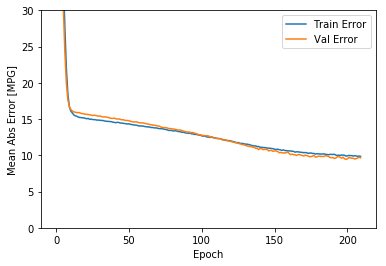

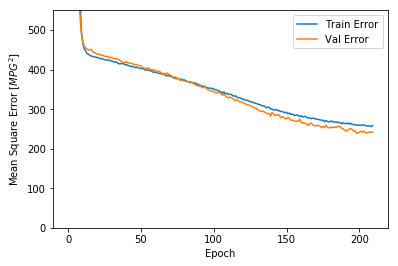

In [402]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,550])
    plt.legend()
    plt.show()


plot_history(history)


In [403]:
def unnorm(x):
    return (x * train_stats['std']) +  train_stats['mean']

In [404]:
test_dataset.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B15-Hap2,AX-95152265,AX-94653866,Chr7D-B16-Hap1,Chr7D-B16-Hap2,Chr7D-B17-Hap1,Balcarce,Azul,MsJz,city
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,Azul
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,MsJz


In [405]:

def f_city(x):
    if x['Balcarce'] == 1.0: return 'Balcarce'
    if x['Azul'] == 1.0: return 'Azul'
    if x['MsJz'] == 1.0: return 'MsJz'

test_dataset['city'] = test_dataset.apply(f_city, axis=1)



In [ ]:


def f_year(x):
    if x['2012'] == 1.0: return '2012'
    if x['2013'] == 1.0: return '2013'
    if x['2014'] == 1.0: return '2014'
    if x['2015'] == 1.0: return '2015'
    if x['2016'] == 1.0: return '2016'

test_dataset['year'] = test_dataset.apply(f_year, axis=1)

In [407]:
test_dataset.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B15-Hap2,AX-95152265,AX-94653866,Chr7D-B16-Hap1,Chr7D-B16-Hap2,Chr7D-B17-Hap1,Balcarce,Azul,MsJz,city
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,Azul
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,MsJz


In [408]:
test_dataset.year.unique()

AttributeError: 'DataFrame' object has no attribute 'year'

In [409]:
test_labels[:10]

11    83.45
23    38.98
24    43.61
25    51.90
28    80.80
32    62.54
33    66.67
36    38.66
41    24.27
43    38.01
Name: FE, dtype: float64

In [410]:
example_batch = normed_test_data
example_result = model.predict(example_batch)
example_result[:10]


array([[82.5743  ],
       [45.151447],
       [45.151447],
       [45.151447],
       [79.58875 ],
       [76.45699 ],
       [76.45699 ],
       [34.448307],
       [34.448307],
       [34.448307]], dtype=float32)

In [411]:
res = [x[0] for x in example_result]

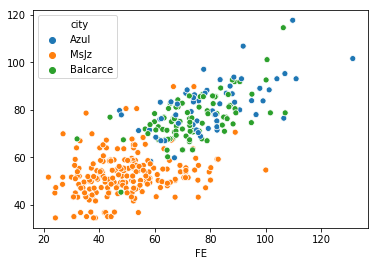

In [412]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.city)
plt.show()

In [ ]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.year)
plt.show()

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
